In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit
import scipy as sps

Поиск точного решения из прошлой лабы

In [2]:
@jit(nopython=True)
def dot(first, second):
    return np.sum(first * second)
@jit(nopython=True)
def norm(vec):
    return np.power(dot(vec, vec), 0.5)
@jit(nopython=True)
def find_QR(A):
    Q = np.zeros(A.shape)
    for ind in range(A.shape[1]):
        p_ind = A[:, ind]
        for i in range(ind):
            p_ind -=   Q[:, i] * dot(p_ind, Q[:, i])
        Q[:, ind] = p_ind / norm(p_ind)
    R = Q.T @ A
    return Q, R

Теперь, нужно реализовать метод обратной подстановки для решения системы с матрицей $R$. Напомним, что для того, чтобы найти решение $Ax=b$, где $A = QR$, нужно заметить, что
$$
Ax = b \Leftrightarrow QRx = b \Leftrightarrow Q^TQRx = Q^Tb \Leftrightarrow Rx = Q^Tb
$$, то есть нужно решить $Rx = y$, где $y = Q^Tb$.

In [3]:
def find_reverse(A, b):
    x = np.zeros(len(b))
    for ind in range(len(b) - 1, -1, -1):
        x[ind] = (b[ind] - np.sum(A[ind, ind + 1:] * x[ind + 1:])) / A[ind, ind]
    return x

Теперь, общая функция решения система выглядит так:

In [4]:
def solve(A, b):
    Q, R = find_QR(A)
    y = Q.T @ b
    x = find_reverse(R, y)
    return x, Q, R

Имплементируем алгоритм Ричардсона, который итеративно находит решение системы $Ax = b$  c заданной точностью. Напомним теоритическую составляющую алгоритма: 

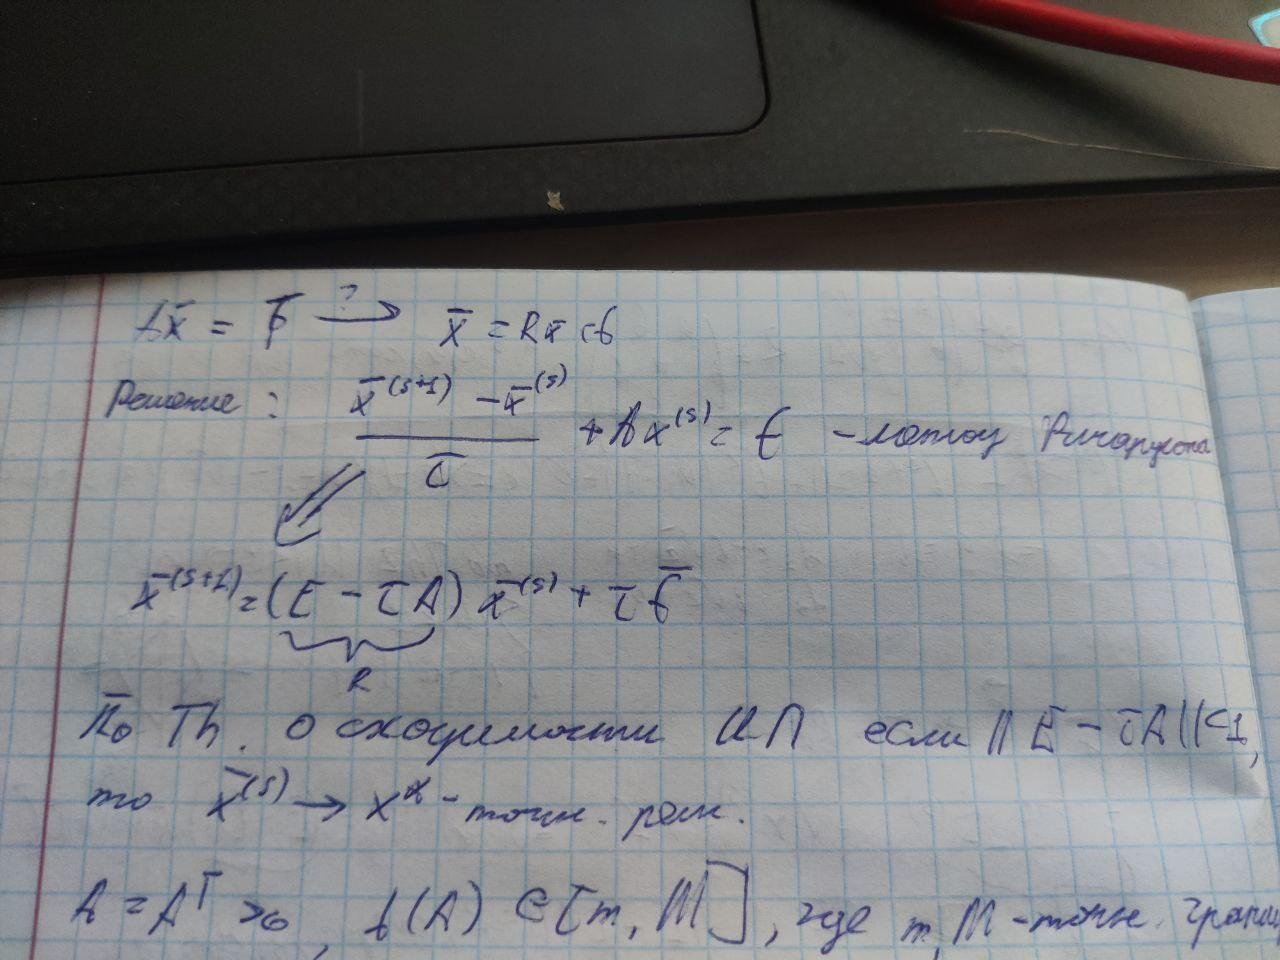

Асимптотика решения будет $O(n^2k)$, где $k$ -- количество итераций, $n$ -- размер матрицы.

In [5]:
@jit(nopython=True)
def dot(first, second):
    return np.sum(first * second)
@jit(nopython=True)
def norm(vec):
    return np.power(dot(vec, vec), 0.5)
@jit(nopython=True)
def find_Richardson_sol(A, b, r, tol, k_max = 100):
    R = np.eye(A.shape[0]) - r * A
    c = r * b

    y = c
    euqlid_norms = np.empty(0)
    for it in range(k_max):
        y = R @ y + c
        euqlid_norms = np.append(euqlid_norms, norm(A @ y - b))
        if euqlid_norms[-1] < tol:
            break
    return y, euqlid_norms, it

Теперь, найдем диапазон, где могут находиться собственные значения с помощью кругов Гершгорина. Сразу отметим, что так как по условию у нас матрица симметричная, достаточно выражать только один вид кругов. Затем брать максимальное значение среди левых границ, и минимальное среди правых границ.

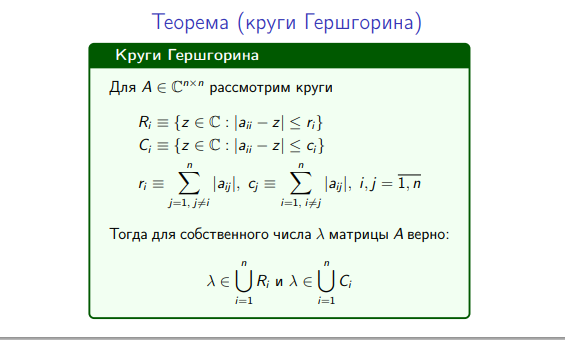

In [6]:
def find_circles(A):
    A_abs = np.abs(A.copy())
    a_ii = np.diag(A_abs)
    r_i_plus_ai = np.sum(A_abs, axis = 0)
    r_i_minus_ai = np.sum(A_abs, axis = 0) - 2 * a_ii
    return np.max(r_i_minus_ai), np.min(r_i_plus_ai)

В задании нас просят найти оптимальное значение $\tau$.  Выпишем аналитически, как оно получилось. Также, выпишем скорость сходимости.

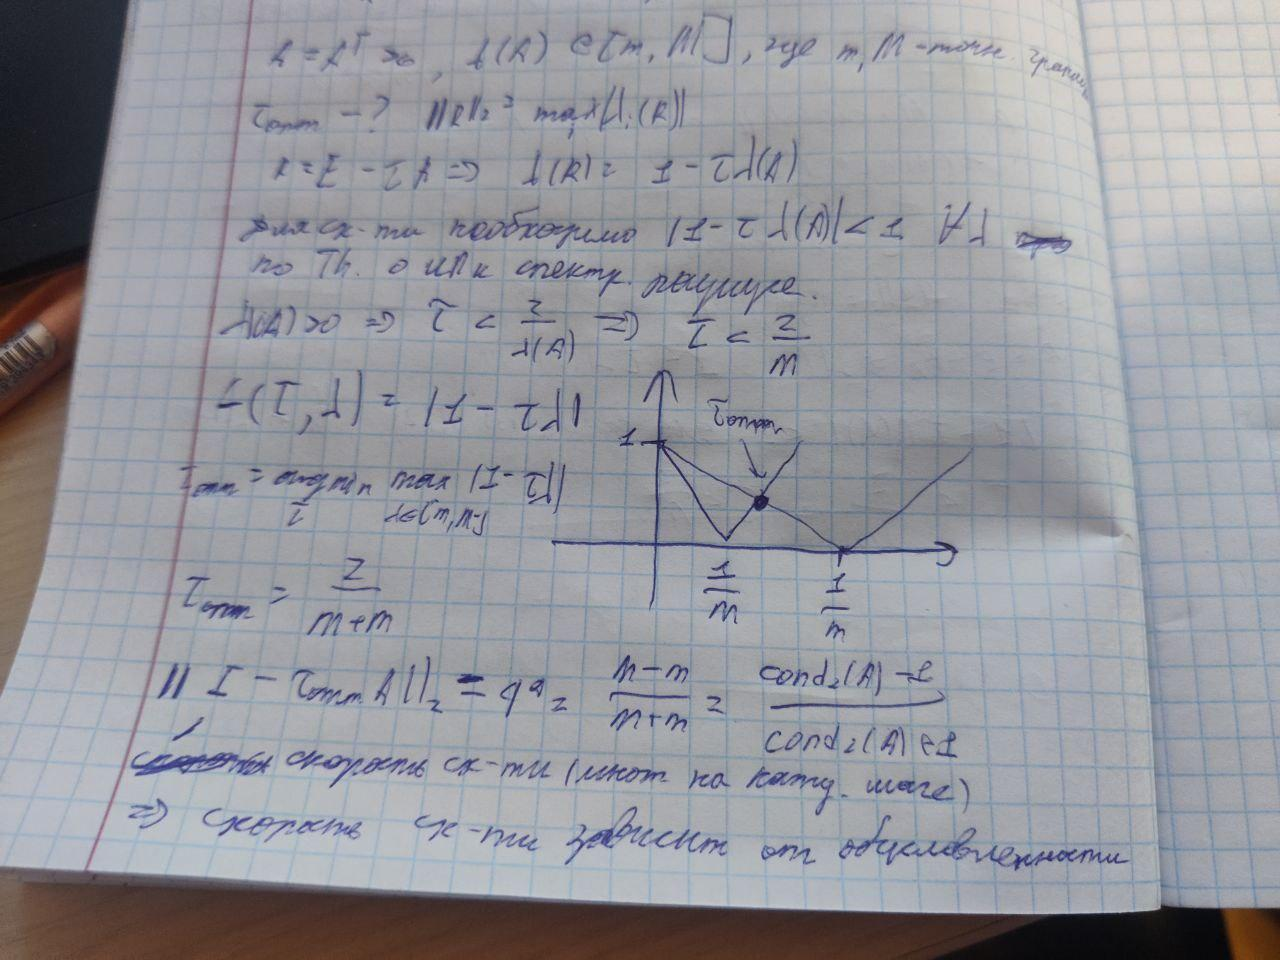

 То есть, на плохо обусловленных матрицах сходиться можем очень долго. Положительность матрицы нам нужна, чтобы оценивать $\tau$ в данном алгоритме с одной стороны. Симметричность использовали для поиска кругов.

Теперь, можно сгенерировать нужные $\tau$ по условию задачи:

In [7]:
def find_u(A):
    lam_min = np.abs(np.min(np.linalg.eigvals(A)))
    lam_max = np.abs(np.max(np.linalg.eigvals(A)))

    e_lam_min, e_lam_max = find_circles(A)

    u_rand = np.random.uniform(0, 2 / e_lam_max)
    if u_rand >= 2/lam_max:
        u_rand = 1.9/lam_max
    u_best = 2 / (lam_max + lam_min)
        
    u_exact = 2 / (e_lam_max + e_lam_min)
    if u_exact >= 2/lam_max:
        u_exact = 1.9/lam_max
        
    return u_rand,u_exact, u_best

## Пример корректности решения

In [24]:
A = np.array([[2, 0, 1], [0, 1, 0], [1, 0, 2]]).astype(np.float64)
b = np.array([3, -1, 3]).astype(np.float64)
_, _, exact = find_u(A)
print('Решение из коробки --',solve(A, b)[0])
print("Решение методом Ричардсона с оптимальным tau -- ",find_Richardson_sol(A, b, exact, 1e-3, 5000)[0])

Решение из коробки -- [ 1.8 -1.   1. ]
Решение методом Ричардсона с оптимальным tau --  [ 1.80007913 -0.99902344  0.9999286 ]


/tmp/ipykernel_120146/2924216575.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  u_exact = 2 / (e_lam_max + e_lam_min)


In [28]:
def times_dif_and_norm_plot(A, b, k_max = 1000, tol = 1e-3):
    start_exact_time = time.time()
    exact_ans = solve(A.copy(), b)[0]
    end_exact_time = time.time()
    
    u_rand, u_exact, u_best = find_u(A)
    
    start_rand_time = time.time()
    x_rand, norms_rand, _ = find_Richardson_sol(A, b, u_rand, tol, k_max)
    end_rand_time = time.time()
    
    start_est_time = time.time()
    x_exact_est, norms_exact_est, _ = find_Richardson_sol(A, b, u_exact,tol, k_max)
    end_est_time = time.time()
    
    start_exact_u_time = time.time()
    x_best, norms_best, _ = find_Richardson_sol(A, b, u_best,tol, k_max)
    end_exact_u_time = time.time()
    
    
    print("\nВремя решения")
    print(f"Точного решения: {end_exact_time - start_exact_time}")
    print(f"tau - произвольное значение из допустимой области: {end_rand_time - start_rand_time}")
    print(f"tau - оптимальное значение, вычисленное по оценкам с.ч.: {end_est_time - start_est_time}")
    print(f"tau - оптимальное значение, вычисленное по точным с.ч.: {end_exact_u_time - start_exact_u_time}")
    
    print("\nНорма разности между точными решением и приближенным:")
    print(f"tau - произвольное значение из допустимой области: {norm(exact_ans - x_rand)}")
    print(f"tau - оптимальное значение, вычисленное по оценкам с.ч.: {norm(exact_ans - x_exact_est)}")
    print(f"tau - оптимальное значение, вычисленное по точным с.ч.: {norm(exact_ans - x_best)}")
    
    plt.figure(figsize=(16, 10))
    plt.plot(np.arange(norms_rand.shape[0]),
             np.log(norms_rand),
             label = r"$\tau$ - произвольное значения из допустимой области",
             color = 'red')
    plt.plot(
        np.arange(norms_exact_est.shape[0]),
        np.log(norms_exact_est), 
        label = r"$\tau$ - оптимальное значение, вычисленное по оценкам с.ч.",
        color = 'yellow'
    )
    plt.plot(np.arange(norms_best.shape[0]), 
             np.log(norms_best),
             label = r"$\tau$ - оптимальное значение, вычисленное по точным с.ч.",
             color = 'green'
            )
    plt.legend()
    plt.title("Графики зависимости логарифма нормы невязки от номера итерации")
    plt.show()
    

Для тестирования создадим функцию, которая будет нам создавать симметричную матрицу вместе со столбцом заданного размера:

In [29]:
def create_A_b(n):
    A = np.random.randn(n, n)
    A = A.T @ A + np.eye(n)
    b = np.random.randn(n)
    return A, b


Время решения
Точного решения: 0.001531362533569336
tau - произвольное значение из допустимой области: 0.003939628601074219
tau - оптимальное значение, вычисленное по оценкам с.ч.: 0.0014405250549316406
tau - оптимальное значение, вычисленное по точным с.ч.: 0.0014662742614746094

Норма разности между точными решением и приближенным:
tau - произвольное значение из допустимой области: 0.8552588600467058
tau - оптимальное значение, вычисленное по оценкам с.ч.: 0.8552657934475186
tau - оптимальное значение, вычисленное по точным с.ч.: 0.8556813013707154


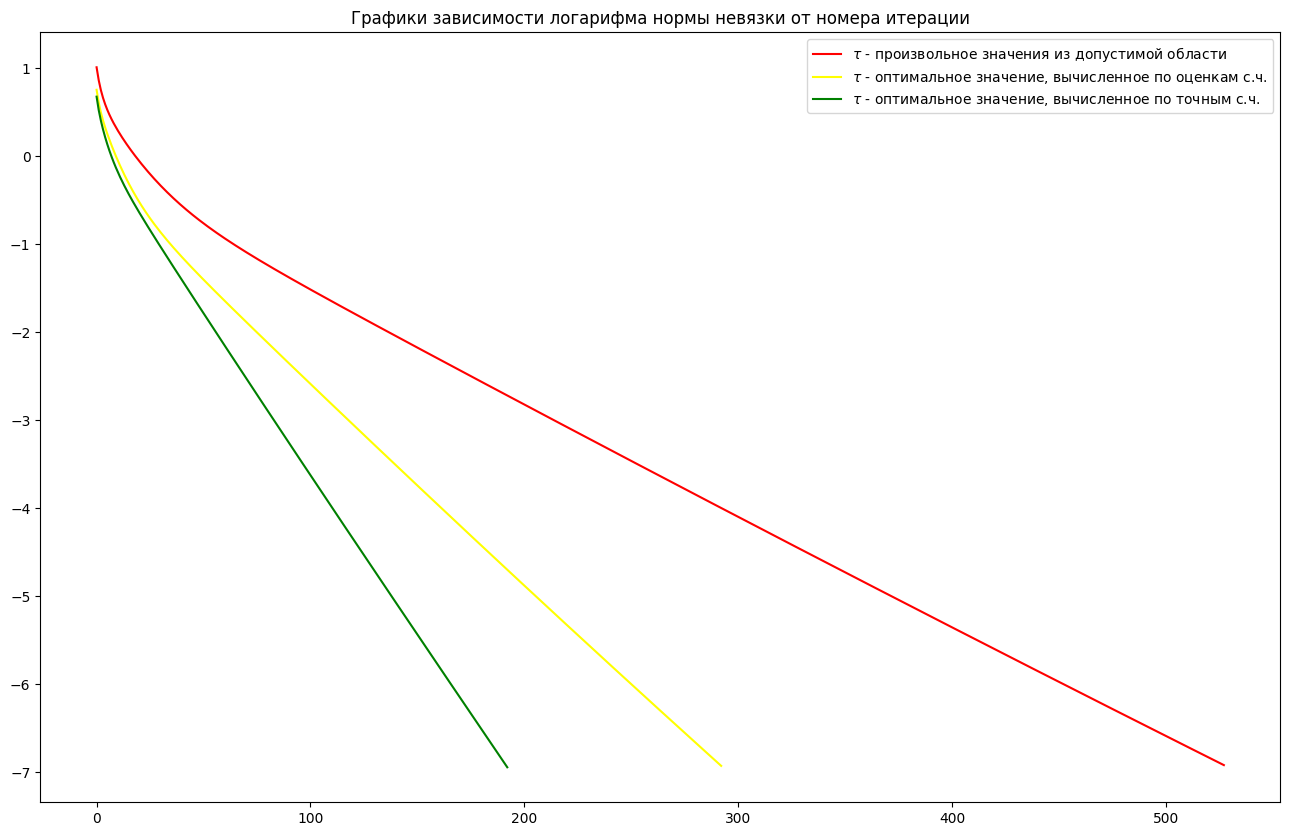

In [30]:
A, b = create_A_b(20)
times_dif_and_norm_plot(A, b, k_max = 5000)

Как мы видим, разность нормы итерационного решения и точного решения действительно стремится к нулю. Причем, значительную роль играет выбор $\tau$ - можем увидеть на графике, что при оптимально выбранном $\tau$ решение быстрее сходится.


Время решения
Точного решения: 0.32120823860168457
tau - произвольное значение из допустимой области: 0.02712106704711914
tau - оптимальное значение, вычисленное по оценкам с.ч.: 0.030500411987304688
tau - оптимальное значение, вычисленное по точным с.ч.: 0.028421640396118164

Норма разности между точными решением и приближенным:
tau - произвольное значение из допустимой области: 0.6336454127638205
tau - оптимальное значение, вычисленное по оценкам с.ч.: 0.6842505073670014
tau - оптимальное значение, вычисленное по точным с.ч.: 1.789831619228064


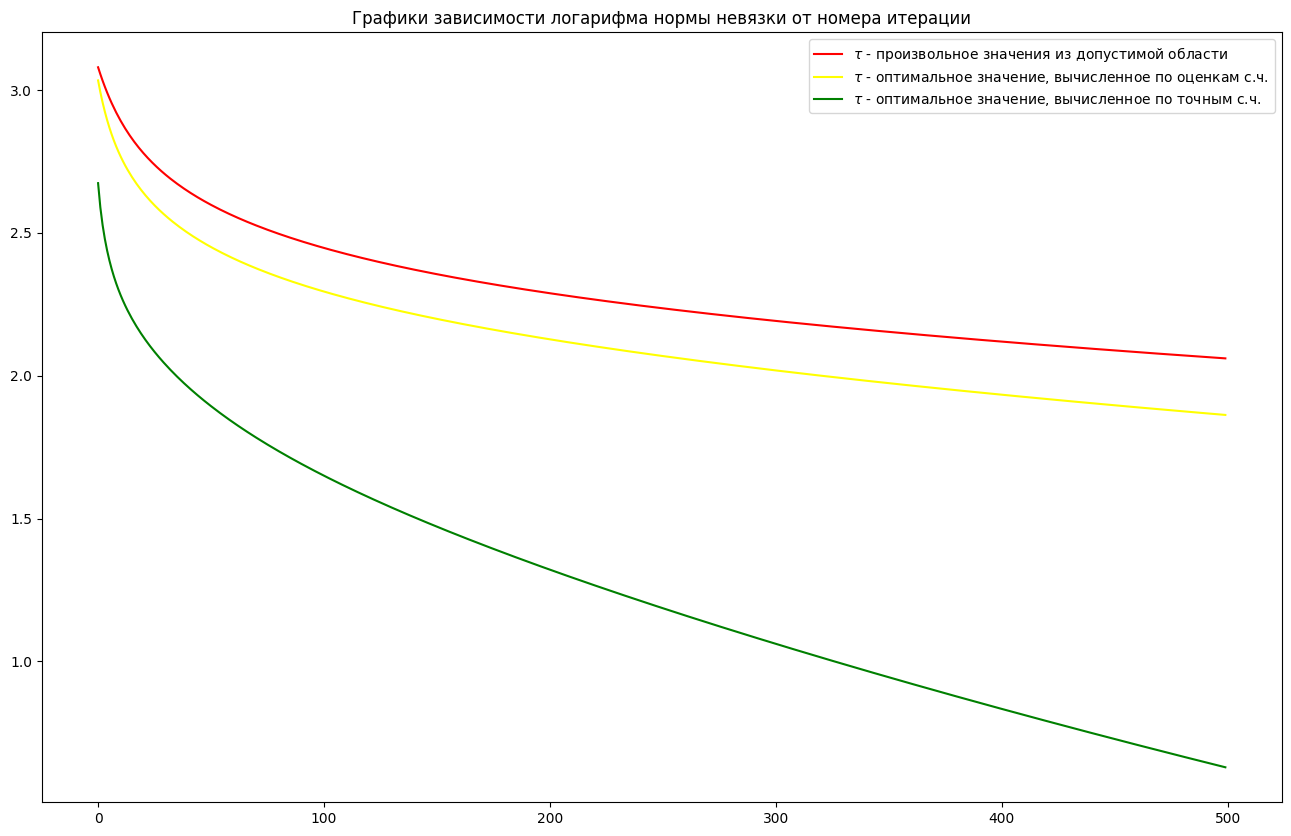

In [31]:
A, b = create_A_b(500)
times_dif_and_norm_plot(A, b, k_max = 500)

Как можем заметить,итеративный метод работает сильно быстрее точного поиска, даже если число итераций брать $O(n)$.

##  Преимущества по сравнению с другими методами
Так как метод простой итерации, скорее он проигрывает другим методам. Например, методу Зейделя он проигрывает в точности (накопительная ошибка там меньше) и чаще дает более лучшую сходимость (особенно на плохо обусловленных матрицах). 